In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
#getting stock data
stocks=['AAPL','WMT','TSLA','GE','AMZN','DB']
start_date='2018-01-01'
end_date='2024-01-01'

def download_data():
  df={}
  for stock in stocks:
    ticker=yf.Ticker(stock)
    df[stock]=ticker.history(start=start_date,end=end_date)['Close']
  return pd.DataFrame(df)


In [3]:
def show_data(data):
  data.plot(figsize=(18,5))
  plt.show()

In [4]:
def calculate_return(data):
  log_return=np.log(data/data.shift(1))
  return log_return[1:]

In [5]:
def show_statistics(returns):
  #annual return using mean
  print(returns.mean()*252)

  #remember covariance is matrix so it will return that
  print(returns.cov()*252)

In [6]:
#caculating annual portfolio return and overall volatility of portfolio
def show_mean_variance(returns,weights):
  portfolio_return=np.sum(returns.mean()*weights)*252
  portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
  print("Expected portfolio mean(return):",portfolio_return)
  print("Expected portfolio volatility(standerd deviation):",portfolio_volatility)


In [7]:
def generate_portfolios(returns):
  portfolio_means=[]
  portfolio_risks=[]
  portfolio_weights=[]

  for i in range(10000):
    w=np.random.random(len(stocks))
    w/=np.sum(w)
    portfolio_weights.append(w)
    portfolio_means.append(np.sum(returns.mean()*w)*252)
    portfolio_risks.append(np.sqrt(np.dot(w.T,np.dot(returns.cov()*252,w))))

  return np.array(portfolio_weights),np.array(portfolio_means),np.array(portfolio_risks)



In [8]:
def show_portfolios(returns,volatilities):
  plt.figure(figsize=(18,6))
  plt.scatter(volatilities,returns,c=returns/volatilities,marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharp Ratio')
  plt.show()

In [9]:
def statistics(weights,returns):
  portfolio_return=np.sum(returns.mean()*weights)*252
  portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
  return np.array([portfolio_return,portfolio_volatility,portfolio_return/portfolio_volatility])


In [10]:
#scipy find min of given function so we wil find min of -f(x) to get max of f(x)
#f(x)=0 this is the function to minimize
def min_function_sharp(weights,returns):
  return -statistics(weights,returns)[2]


In [11]:
def optimize_portfolio(weights,returns):
  constrains={'type':'eq','fun':lambda x:np.sum(x)-1}
  #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
  bounds=tuple((0,1) for _ in range(len(stocks)))
  return optimization.minimize(fun=min_function_sharp,x0=weights[0],args=returns,method='SLSQP',bounds=bounds,constraints=constrains)


In [12]:
def print_optimal_portfolio(optimum,returns):
  print("Optimal portfolio:",optimum['x'].round(3))
  print("Expected return,volatility and sharp ratio:",statistics(optimum['x'].round(3),returns))

In [13]:
def show_optimal_portfolios(opt,rets,portfolio_rets,portfolio_vols):
  plt.figure(figsize=(10,6))
  plt.scatter(portfolio_vols,portfolio_rets,c=portfolio_rets/portfolio_vols,marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharp Ratio')
  plt.plot(statistics(opt['x'],rets)[1],statistics(opt['x'],rets)[0],'g*',markersize=20)
  plt.show()

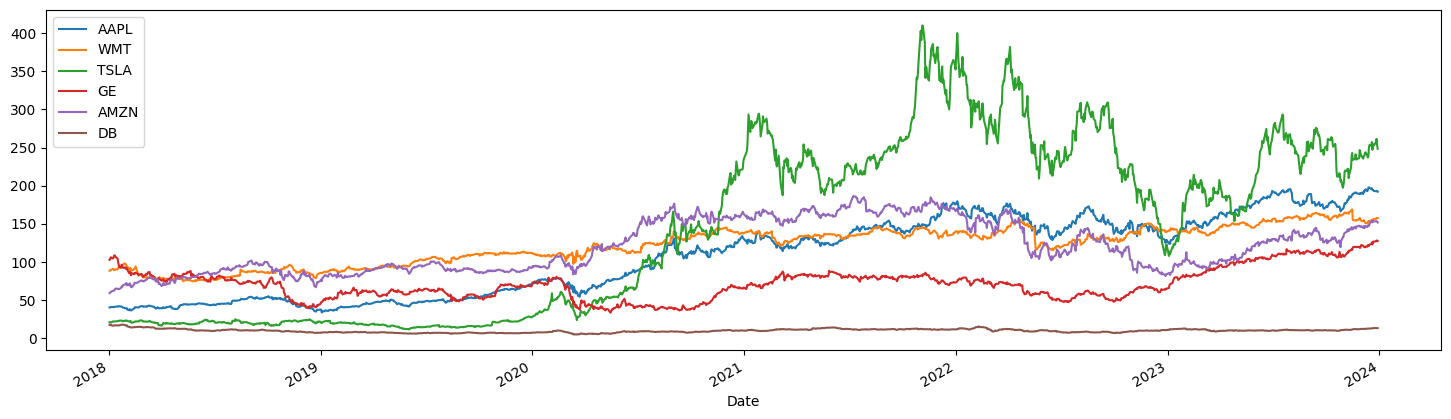

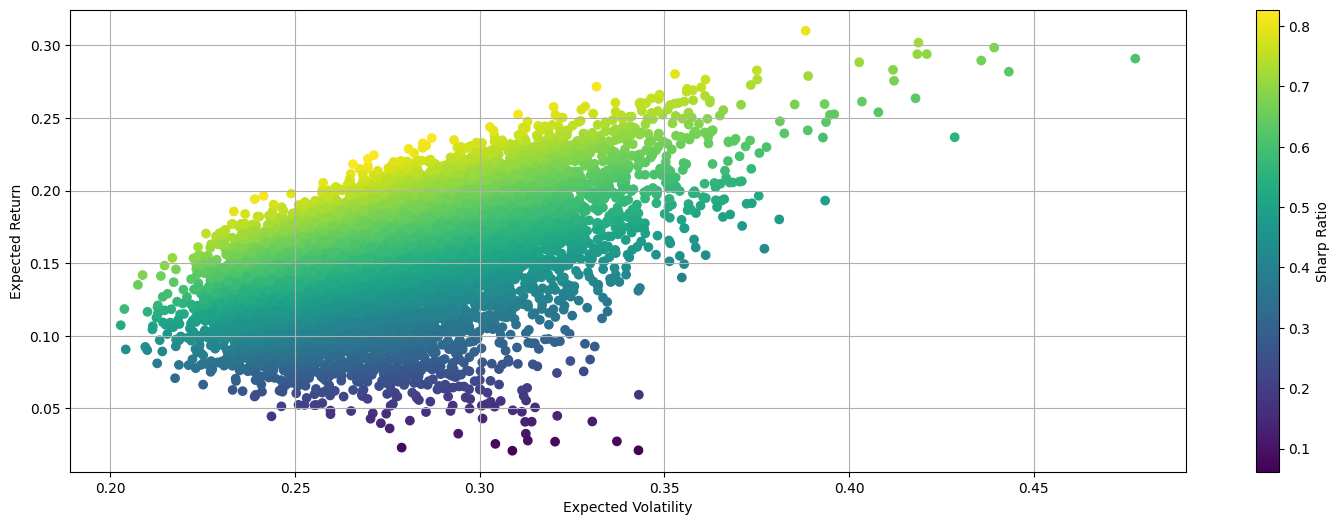

Optimal portfolio: [0.614 0.218 0.167 0.    0.    0.   ]
Expected return,volatility and sharp ratio: [0.248844   0.2824     0.88117564]


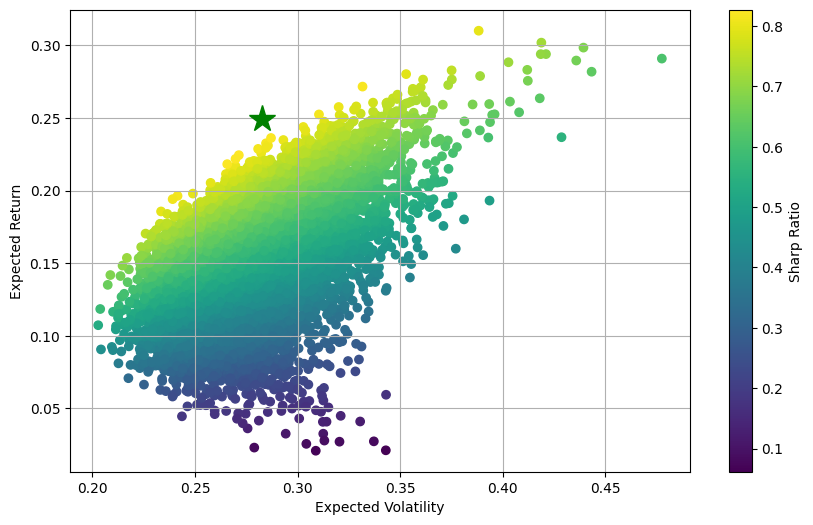

In [14]:
if __name__=='__main__':
  dataset=(download_data())
  show_data(dataset)
  log_daily_returns=calculate_return(dataset)
  #show_statistics(log_daily_returns)

  pweights,means,risks=generate_portfolios(log_daily_returns)
  show_portfolios(means,risks)
  optimum=optimize_portfolio(pweights,log_daily_returns)
  print_optimal_portfolio(optimum,log_daily_returns)
  show_optimal_portfolios(optimum,log_daily_returns,means,risks)
